# Condition survey datasets

This script loads and conditions the survey datasets into a single final dataframe containing the columns for the investigation

Conditioning is performed by transforming column names and categorical data to standard values, using extensive use of pandas map function

Dummy variables / one-hot-encoding is used for multiselect categorical options

Name selection was conducted manually as the process requires domain knowledge and some personal judgement.

- Value names: the completed map dict is stored in map_values.py. The dict tempate was generated using prep_label_standardisation()
- Column names: stored in csv files in the schemas folder Templates were generated with gen_schemas.py

In [23]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from routines import xzsave, load, prep_label_standardisation

pd.set_option('display.max_columns', None)

Define columns of interest, selected after an preliminary analysis of the questions across surveys

In [24]:
interest_cols = [
    'salary',
    'satisfaction',
    'age',
    'gender',
    'years_coding',
    'occupation',
    'employment',
    'industry',
    'org_size',
    'job_seek',
    'remote',
    'education',
    'undergrad',
    'os',
    'occu_nondev',  # 2017 - to be folded into occupation
    'occu_web', # 2017 - fold into occupation
    'edu_other'  # 2017+ - to be folded into education 
]

load the survey data in to a list, using the load function in routines.py

In [25]:
surveys = [
    load(2011, "2011 Stack Overflow Survey Results.csv", 2),
    load(2012, "2012 Stack Overflow Survey Results.csv", 2),
    load(2013, "2013 Stack Overflow Survey Responses.csv", 2),
    load(2014, "2014 Stack Overflow Survey Responses.csv", 2),
    load(2015, "2015 Stack Overflow Developer Survey Responses.csv", 2),
    load(2016, "2016 Stack Overflow Survey Results/2016 Stack Overflow Survey Responses.csv", 1),
    load(2017, "developer_survey_2017/survey_results_public.csv", 1),
    load(2018, "developer_survey_2018/survey_results_public.csv", 1),
    load(2019, "developer_survey_2019/survey_results_public.csv", 1),
    load(2020, "developer_survey_2020/survey_results_public.csv", 1),
]

2011 respondents: 2813, columns: 66
2012 respondents: 6243, columns: 76
2013 respondents: 9742, columns: 129
2014 respondents: 7643, columns: 121
2015 respondents: 26086, columns: 223
2016 respondents: 56030, columns: 65
2017 respondents: 51392, columns: 155
2018 respondents: 98855, columns: 130
2019 respondents: 88883, columns: 86
2020 respondents: 64461, columns: 62


We can see how both the number of respondents and amount of columns (tracking with number of questions) varies quite a bit across the years. In particular it is clear that the survey increased dramatically in 2015 and peaked in 2018.

Now, lets programatically identify which years contain the column of interest defined above

In [4]:
ft = pd.DataFrame(columns=interest_cols, index=range(2011, 2021))
for s, y in zip(surveys, range(2011, 2021)):
    ft.loc[y] = ft.columns.map(lambda x: x in s.columns)

ft.T

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
salary,True,True,True,True,True,True,True,True,True,True
satisfaction,True,True,True,False,True,True,True,True,True,True
age,True,True,True,True,True,True,False,True,True,True
gender,False,False,False,True,True,True,True,True,True,True
years_coding,True,True,True,True,True,True,True,True,True,True
occupation,True,True,True,True,True,True,True,True,True,True
employment,False,False,False,False,True,True,True,True,True,True
industry,True,True,True,True,True,True,True,False,False,False
org_size,True,True,True,False,False,True,True,True,True,True
job_seek,False,False,False,True,True,True,True,True,True,True


As we can see, there isn't a lot of consistency between the datasets. However, each question is present for at least 5 years.

at this point the value mapping dict template can be created using a separate function


In [5]:
prep_label_standardisation(surveys, interest_cols, split=';')

{
    "salary": {
        "$10,000 - $20,000" : ,
        "$100,000 - $110,000" : ,
        "$100,000 - $120,000" : ,
        "$110,000 - $120,000" : ,
        "$120,000 - $130,000" : ,
        "$120,000 - $140,000" : ,
        "$130,000 - $140,000" : ,
        "$140,000 - $150,000" : ,
        "$140,000 - $160,000" : ,
        "$150,000 - $160,000" : ,
        "$160,000 - $170,000" : ,
        "$170,000 - $180,000" : ,
        "$180,000 - $190,000" : ,
        "$190,000 - $200,000" : ,
        "$20,000 - $30,000" : ,
        "$20,000 - $40,000" : ,
        "$30,000 - $40,000" : ,
        "$40,000 - $50,000" : ,
        "$40,000 - $60,000" : ,
        "$50,000 - $60,000" : ,
        "$60,000 - $70,000" : ,
        "$60,000 - $80,000" : ,
        "$70,000 - $80,000" : ,
        "$80,000 - $100,000" : ,
        "$80,000 - $90,000" : ,
        "$90,000 - $100,000" : ,
        "<$20,000" : ,
        ">$140,000" : ,
        "Less than $10,000" : ,
        "Less than $20,000" : ,
        "Mo

This function identifies unique values, making it easy to study at nature of the questions and answers.

- Ranged questions like salary and age were converted to median values.
- For some questions it seems like the software used became confused and tried to convert the values to a date (years_coding in particular)
- The salary map upper limit increases overtime, perhaps making it appear that the annual salary increases artificially
- questions about education were simplified to focus on level of formal education, and types of non-standard (e.g. bootcamps)

The finished dict was saved in map_values.py

In [6]:
from map_values import value_map

## standardise dummy variables

The 2011 - 2015 csv files use dummy columns for multiselect questions, which are transformed to boolean

The column names for these years have already been necesssarily transformed as the original columns were the question text

In [7]:
split_2011 = [
    "lang",
    "education"
]

for df in surveys[:5]:
    print(pd.unique(df["survey_year"]))
    for col in split_2011:
        c = df.columns.map(lambda x: x.startswith(col+'_'))
        df.loc[:, c] = df.loc[:, c].fillna(0)
        df.loc[:, c] = df.loc[:, c].ne(0).mul(1)

[2011]
[2012]
[2013]
[2014]
[2015]


from 2016, certain columns became multicategorical stored as strings separated by ";"

We will also standardise the column names in the process. This is a bit tricky
1. split string into a list, transform items and remove duplicates
2. return to a string so pandas can work it's magic (str.get_dummies) to account for the variable lengths

In [8]:
split_2016 = [
    "occupation",
    "occu_nondev",
    "occu_web",
    "education",
    "edu_other"
]


def map_vals_list(x, col):
    try:
        return ';'.join(set([value_map[col][xi] for xi in x]))
    except TypeError:
        return x


for i, df in enumerate(surveys[5:]):
    print(pd.unique(df['survey_year']))
    new_cols = [df]
    for col in split_2016:
        if col in df:
            a = df.pop(col)
            a = a.str.split(r'\s*;\s*')
            a = a.map(lambda x: map_vals_list(x, col))
            a = a.str.get_dummies(';')
            a = a.rename(columns=lambda x : f'{col}_{x}')
            new_cols.append(a)
    surveys[i+5] = pd.concat(new_cols, axis=1)

[2016]
[2017]
[2018]
[2019]
[2020]


change edu_other to education

In [9]:
for df in surveys[5:]:
    for col in df.columns:
        if col.startswith('edu_other_'):
            col2 = "education_" + col.split('_', 2)[-1]
            df.rename(columns={col: col2}, inplace=True)
        if col.startswith('occu_web_'):
            col2 = "occupation_" + col.split('_', 2)[-1]
            df.rename(columns={col: col2}, inplace=True)

print("bootcamp percentage")
for survey in surveys:
    try:
        print(survey["survey_year"].mean(), survey["education_bootcamp"].mean()*100)
    except KeyError:
        pass


bootcamp percentage
2015.0 2.8176033121214443
2016.0 5.0312332678922
2017.0 5.306273349937733
2018.0 7.067927773000859
2019.0 14.557339423736822


## General transformation of variable data using the value map

From 2016, gender selection is multiselect, resulting in a wide range of options

In [10]:
unique = []
for df in surveys:
    if "gender" in df and df["gender"].dtype == object:
        unique.extend(list(pd.unique(df["gender"].dropna())))
sorted(list(set(unique)))

['Female',
 'Female; Gender non-conforming',
 'Female; Gender non-conforming; Other',
 'Female; Other',
 'Female; Transgender',
 'Female; Transgender; Gender non-conforming',
 'Female; Transgender; Gender non-conforming; Other',
 'Female; Transgender; Other',
 'Female;Male',
 'Female;Male;Non-binary, genderqueer, or gender non-conforming',
 'Female;Male;Transgender',
 'Female;Male;Transgender;Non-binary, genderqueer, or gender non-conforming',
 'Female;Non-binary, genderqueer, or gender non-conforming',
 'Female;Transgender',
 'Female;Transgender;Non-binary, genderqueer, or gender non-conforming',
 'Gender non-conforming',
 'Gender non-conforming; Other',
 'Male',
 'Male; Female',
 'Male; Female; Gender non-conforming',
 'Male; Female; Gender non-conforming; Other',
 'Male; Female; Other',
 'Male; Female; Transgender',
 'Male; Female; Transgender; Gender non-conforming',
 'Male; Female; Transgender; Gender non-conforming; Other',
 'Male; Female; Transgender; Other',
 'Male; Gender non-

the dataset will be split into female, male and other/genderqueer/non-binary/non-conforming

To simplify analysis, if one than one value is present then the respondant is assumed to identify outside the male/female dichotomy.

An alternative approach would be to select only the category item in the list, but that will clearly miss out on important information.

In [11]:
def map_gender(x):
    if x == np.nan:
        return
    try:
        # x = re.split(r'\s*;\s*', x)[0]  # only use first
        return value_map["gender"][x]
    except KeyError:
        return "other"


for df in surveys[5:]:
    df["gender"] = df["gender"].map(map_gender)


2017 and 2018 satisfactions use different approachs, so we need to bucket to match other years

In [12]:
surveys[6]['satisfaction'] = pd.cut(
    surveys[6]['satisfaction'],
    [0, 2, 4, 6, 8, 10],
    labels=[1, 2, 3, 4, 5]
).astype(float)

In [13]:
# 

Now that everything is in place the actual function itself is quite simple.

The Try/Except takes care of empty entries

In [14]:
def map_vals(x, col):
    try:
        return value_map[col][x]
    except KeyError:
        return x


for df in surveys:
    for col in interest_cols:
        if col in df.columns:
            df[col] = df[col].map(lambda x : map_vals(x, col))

modify the 2011-2015 single answer questions to match the multianswer dummy format of the later years

In [15]:
dummy_2016 = [
    "occupation",
    "education",
]

for i, df in enumerate(surveys[:5]):
    new_cols = [df]
    for col in dummy_2016:
        if col in df.columns:
            new_cols.append(pd.get_dummies(df.pop(col), prefix=col))
    surveys[i] = pd.concat(new_cols, axis=1)

As a final step, we need to merge the separate 2017+ occupation columns, which overlap

In [16]:
df = surveys[6]
print(pd.unique(df["survey_year"]))
print("percent data scientists before merge: ", df["occupation_data_scientist"].mean()*100)
for col in df.columns:
    if col.startswith('occu_nondev_'):
        col2 = "occupation_" + col.split('_', 2)[-1]
        if col2 not in df.columns:
            df = df.rename(columns={col: col2})  # just rename if the ouccupation col doesn't exist
        else:
            df[col2] = df.apply(lambda x: x[col] if x[col2]==0 else x[col2], axis=1)
            df.drop(columns=[col])
print("percent data scientists after merge: ", df["occupation_data_scientist"].mean()*100)


[2017]
percent data scientists before merge:  6.9952521793275215
percent data scientists after merge:  9.135663138231632


## Final steps

Join surveys together into a single dataframe, and then pick desired columns

In [17]:
df = pd.concat(surveys, ignore_index=True, sort=True)

Select columns of interest

In [18]:
def sel_cols(x):
    if x in ["survey_year", "country"] + interest_cols[:-3]:
        return True
    elif any(x.startswith(c+'_') for c in interest_cols[:-3]):
        return True
    return False

df = df.loc[:, df.columns.map(sel_cols)]
for c in df.columns:
    print(c)

age
country
education_associate_degree
education_bachelors
education_bootcamp
education_college
education_competition
education_doctoral
education_elementary
education_hackathon
education_industry_cert
education_masters
education_mentor
education_night_school
education_no_formal
education_on_the_job
education_online
education_open_source
education_other
education_professional_degree
education_secondary
education_self_taught
employment
gender
industry
job_seek
occupation_DevOps
occupation_QA
occupation_academic
occupation_admin
occupation_analyst
occupation_data_engineer
occupation_data_scientist
occupation_database
occupation_designer
occupation_dev_desktop
occupation_dev_embed
occupation_dev_enterprise
occupation_dev_graphics
occupation_dev_kernel
occupation_dev_mobile
occupation_dev_server
occupation_dev_stats
occupation_dev_web
occupation_dev_web-back
occupation_dev_web-front
occupation_dev_web-full
occupation_executive
occupation_manager
occupation_non-tech
occupation_other
occupat

Finally, fix up a couple of country names. A more thorough process would be needed to do a complete international study of results

In [19]:
df.country.loc[df.country == "United States of America"] = "United States"
df.country.loc[df.country == "Russian Federation"] = "Russia"


/Users/joel/Library/miniforge3/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Lets check a few things to make sure everything is working

In [20]:
df.groupby("survey_year").agg({"education_doctoral":"mean", "occupation_data_scientist":"mean", "occupation_dev_web-full":"mean"})

,education_doctoral,occupation_data_scientist,occupation_dev_web-full
survey_year,,,
2011,NaN,NaN,NaN
2012,NaN,NaN,NaN
2013,NaN,NaN,0.245022
2014,NaN,NaN,0.257229
2015,0.017596,0.021237,0.259335
2016,0.016402,0.021149,0.247832
2017,0.025451,0.069953,0.132628
2018,0.022396,0.071701,0.448667
2019,0.027362,0.072680,0.475029


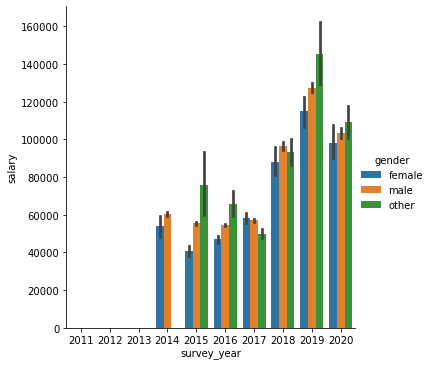

In [21]:
sns.catplot(x="survey_year",       # x variable name
            y="salary",       # y variable name
            hue="gender",  # group variable name
            data=df,     # dataframe to plot
            kind="bar",
            estimator=np.average)

That's a lot whole lot more people identifying as male in the survey

Finally, save the DataFrame for later analysis

In [22]:
xzsave(df, "surveys.pz")